In [1]:
import os
import cv2
from face_tracking import data_collection, process_unknown_faces
import matplotlib.pyplot as plt
import random
import shutil
from helpers import preprocess, deprocess_image, do_data_preprocessing

#### Set paths Global Variables and get Face Detector

In [2]:
CELEB_ORIG_PATH = os.path.join('data', 'img_align_celeba')
FACES_PATH = os.path.join('data', 'faces')
UNKNOWN_FACES_PATH = os.path.join(FACES_PATH, 'unknown_faces')
KNOWN_FACE_PATH = os.path.join(FACES_PATH, 'stephen')   # Change path for different identities
TESTING_PATH = os.path.join('data', 'data', 'testing')
VALIDATION_PATH = os.path.join('data', 'data', 'validation')
TESTING_PATH_POSITIVE = os.path.join(TESTING_PATH, 'positive')
TESTING_PATH_NEGATIVE = os.path.join(TESTING_PATH, 'negative')
VALIDATION_PATH_POSITIVE = os.path.join(VALIDATION_PATH, 'positive')
VALIDATION_PATH_NEGATIVE = os.path.join(VALIDATION_PATH, 'negative')

NUM_IMAGES = 5000

PERCENT_TRAINING = 80
PERCENT_VALIDATION = 20
NUM_AUGMENTATIONS_PER_IMAGE = 50
MODEL_INPUT_IMAGE_DIMENSIONS = (100, 100)

Face_Detector = cv2.dnn.readNetFromCaffe("do_not_delete/deploy.prototxt.txt",
                                             "do_not_delete/res10_300x300_ssd_iter_140000.caffemodel")

#### ONLY RUN IF YOU WANT TO REPROCESS ALL CELEBRITY FACES

In [3]:
'''
for file in os.listdir(UNKNOWN_FACES_PATH):
    file_path = os.path.join(UNKNOWN_FACES_PATH, file)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
'''

"\nfor file in os.listdir(UNKNOWN_FACES_PATH):\n    file_path = os.path.join(UNKNOWN_FACES_PATH, file)\n    try:\n        if os.path.isfile(file_path) or os.path.islink(file_path):\n            os.unlink(file_path)\n        elif os.path.isdir(file_path):\n            shutil.rmtree(file_path)\n    except Exception as e:\n        print('Failed to delete %s. Reason: %s' % (file_path, e))\n"

#### Process, Crop, and move celebrety faces to unknown faces path

In [4]:
if len(os.listdir(UNKNOWN_FACES_PATH)) > 0:
    print("Found files in directory already. To rerun, please empty " + UNKNOWN_FACES_PATH + " by running the code above ^^^")
else:
    process_unknown_faces(input_path=CELEB_ORIG_PATH, output_path=UNKNOWN_FACES_PATH, face_detector=Face_Detector)

Found files in directory already. To rerun, please empty data/faces/unknown_faces by running the code above ^^^


#### ONLY RUN IF YOU WANT TO RETAKE NEW PHOTOS

In [5]:
'''
for file in os.listdir(KNOWN_FACE_PATH):
    file_path = os.path.join(KNOWN_FACE_PATH, file)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
'''

"\nfor file in os.listdir(KNOWN_FACE_PATH):\n    file_path = os.path.join(KNOWN_FACE_PATH, file)\n    try:\n        if os.path.isfile(file_path) or os.path.islink(file_path):\n            os.unlink(file_path)\n        elif os.path.isdir(file_path):\n            shutil.rmtree(file_path)\n    except Exception as e:\n        print('Failed to delete %s. Reason: %s' % (file_path, e))\n"

#### Capture, crop, and process images of target face

In [6]:
if len(os.listdir(KNOWN_FACE_PATH)) > 0:
    print("Found files in directory already. To rerun, please empty " + KNOWN_FACE_PATH + " by running the code above ^^^")
else:
    data_collection(KNOWN_FACE_PATH, 10000)

Found files in directory already. To rerun, please empty data/faces/stephen by running the code above ^^^


#### Delete old files

In [8]:
for dir in os.listdir(os.path.join('data', 'data')):
    if os.path.isdir(os.path.join('data', 'data', dir)):
        for subdir in os.listdir(os.path.join('data', 'data', dir)):
            if os.path.isdir(os.path.join('data', 'data', dir, subdir)):
                for file in os.listdir(os.path.join('data', 'data', dir, subdir)):
                    file_path = os.path.join('data', 'data', dir, subdir, file)
                    try:
                        if os.path.isfile(file_path) or os.path.islink(file_path):
                            os.unlink(file_path)
                        elif os.path.isdir(file_path):
                            shutil.rmtree(file_path)
                    except Exception as e:
                        print('Failed to delete %s. Reason: %s' % (file_path, e))

#### Augment data and move to correct directories

In [9]:
if len(os.listdir(TESTING_PATH_POSITIVE)) > 0 or len(os.listdir(TESTING_PATH_NEGATIVE)) > 0 or len(os.listdir(VALIDATION_PATH_POSITIVE)) > 0 or len(os.listdir(VALIDATION_PATH_NEGATIVE)) > 0:
    print("Found files in directory already. To rerun, please empty " + TESTING_PATH_POSITIVE + ", " + TESTING_PATH_NEGATIVE + ", " + VALIDATION_PATH_POSITIVE + ", and " + VALIDATION_PATH_NEGATIVE + " by running the code above ^^^")
else:
    do_data_preprocessing(num_images=NUM_IMAGES, num_augmentations_per_image=NUM_AUGMENTATIONS_PER_IMAGE, input_dimensions=MODEL_INPUT_IMAGE_DIMENSIONS, known_face_path=KNOWN_FACE_PATH, unknown_face_path=UNKNOWN_FACES_PATH, percent_training=PERCENT_TRAINING, percent_validation=PERCENT_VALIDATION, testing_path_positive=TESTING_PATH_POSITIVE, testing_path_negative=TESTING_PATH_NEGATIVE, validation_path_positive=VALIDATION_PATH_POSITIVE, validation_path_negative=VALIDATION_PATH_NEGATIVE)

Processing 5000 known faces...
5000/5000 [==============================] - ETA: 0:00
Done!
Processing 5000 unknown faces...
5000/5000 [==============================] - ETA: 0:00
Done!


#### Check Data

In [22]:
l1 = os.listdir(TESTING_PATH_POSITIVE)
random.shuffle(l1)
pos = iter(l1)
l2 = os.listdir(TESTING_PATH_NEGATIVE)
random.shuffle(l2)
neg = iter(l2)

(100, 100, 3)


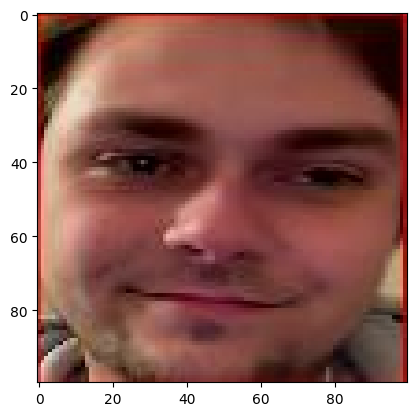

In [27]:
img = deprocess_image(preprocess(os.path.join(TESTING_PATH_POSITIVE, next(pos)), MODEL_INPUT_IMAGE_DIMENSIONS))
print(img.shape)
plt.imshow(img)

(100, 100, 3)


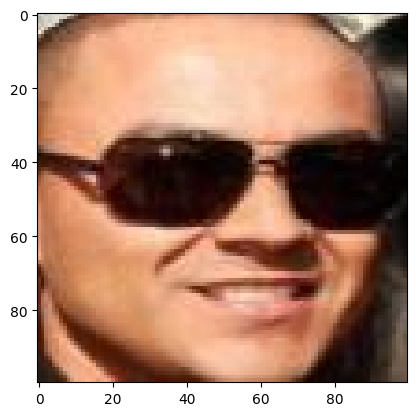

In [30]:
img = deprocess_image(preprocess(os.path.join(TESTING_PATH_NEGATIVE, next(neg)), MODEL_INPUT_IMAGE_DIMENSIONS))
print(img.shape)
plt.imshow(img)